In [2]:
import pandas as pd
import seaborn as sns


# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
states = ['NSW','VIC','SA','QLD']

In [4]:
DATA_PATH = "../../data/UNSW-PROJECT-DATA/"
datafile = "demand_pv_temp_forecast_timefeatures_hols.csv"

# Load the merged demand_pv_temp_forecast merged file. This already has MEAN forecast per demand timepoint (ie: all forecasts for that timepoint averaged)
demand = pd.read_csv(DATA_PATH+datafile)
demand['DATETIME'] = pd.to_datetime(demand['DATETIME'])
demand['SUNRISE'] = pd.to_datetime(demand['SUNRISE'])
demand['SUNSET'] = pd.to_datetime(demand['SUNSET'])

# Rename the FORECAST demand column MEANFORECAST to indicate it has been processed and avoid confusion
demand['MEANFORECAST'] = demand['FORECASTDEMAND']
demand = demand.drop(['FORECASTDEMAND'], axis=1)


In [5]:
demand.isna().sum()
demand['DATETIME'].min()
demand['DATETIME'].max()

STATE                0
DATETIME             0
TOTALDEMAND          0
POWER           513681
LOCATION             0
TEMPERATURE         12
Weekday              0
Quarter              0
Month                0
Season               0
Day                  0
Year                 0
SUNRISE              0
SUNSET               0
DAYTYPE              0
HOLIDAY              0
MEANFORECAST    308351
dtype: int64

Timestamp('2010-01-01 00:00:00')

Timestamp('2021-03-18 00:00:00')

PV data is not available for the entire data period. Define where the PV data begins for each state

In [6]:
demand[demand['POWER'].notna()].groupby(by='STATE')['DATETIME'].min()

STATE
NSW   2018-03-06 09:30:00
QLD   2018-03-06 09:30:00
SA    2018-03-06 09:30:00
VIC   2018-03-06 09:30:00
Name: DATETIME, dtype: datetime64[ns]

Define a new dataframe containing only data for the range containing PV data (pv)

In [7]:
pv = demand[demand['DATETIME'] >= '20180306']
pv.shape
pv.isna().sum()

(212740, 17)

STATE             0
DATETIME          0
TOTALDEMAND       0
POWER           226
LOCATION          0
TEMPERATURE       6
Weekday           0
Quarter           0
Month             0
Season            0
Day               0
Year              0
SUNRISE           0
SUNSET            0
DAYTYPE           0
HOLIDAY           0
MEANFORECAST      0
dtype: int64

# Distribution by state of energy demand over PV-aware period


<AxesSubplot:xlabel='TOTALDEMAND', ylabel='Density'>

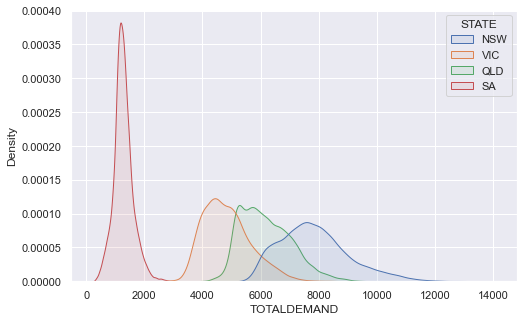

In [8]:
sns.set(rc={"figure.figsize": (8,5)})
sns.kdeplot(data=pv[pv['POWER'].notna()], x='TOTALDEMAND', hue='STATE', fill=True, alpha=0.1)

# Daily distribution of power demand - NSW and VIC

<AxesSubplot:xlabel='Weekday', ylabel='TOTALDEMAND'>

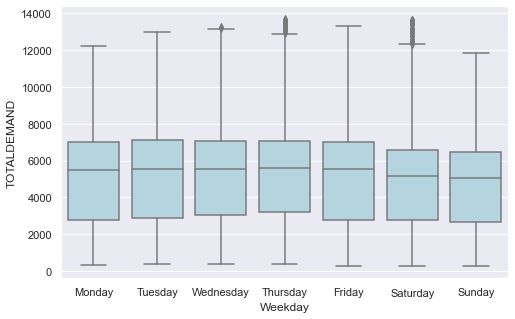

In [38]:
sns.boxplot(data=pv, x=pv['Weekday'], y='TOTALDEMAND', color='lightblue',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [ ]:
# Distribution of temperatures over PV-aware period

<AxesSubplot:xlabel='TEMPERATURE', ylabel='Density'>

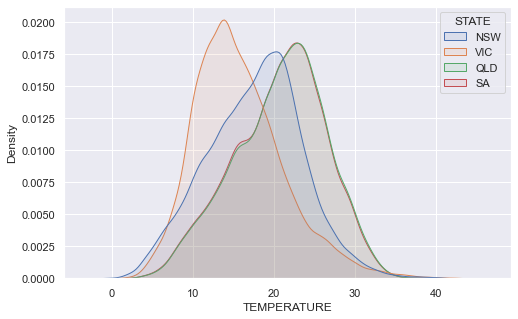

In [26]:
sns.set(rc={"figure.figsize": (8,5)})
sns.kdeplot(data=pv[pv['TEMPERATURE'].notna()], x='TEMPERATURE', hue='STATE', fill=True, alpha=0.1)

<AxesSubplot:xlabel='POWER', ylabel='Density'>

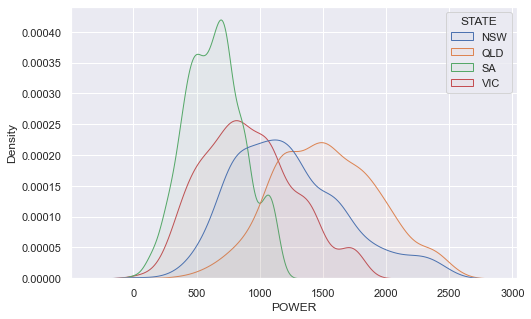

In [27]:
# PV production distribution per state
max_power = pv.groupby([pv['DATETIME'].dt.date, 'STATE']).aggregate({'POWER':max})


sns.set(rc={"figure.figsize": (8,5)})
sns.kdeplot(data=max_power[max_power['POWER'].notna()], x='POWER', hue='STATE', fill=True, alpha=0.05)

In [11]:
max_daily_power_df = demand.groupby([demand['DATETIME'].dt.date, 'STATE']).aggregate({'POWER':max})
max_daily_power_df.head(20)

POWER
DATETIME   STATE       
2010-01-01 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-02 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-03 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-04 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-05 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-06 NSW      NaN
           QLD      NaN
           SA       NaN
2010-01-07 NSW      NaN
           QLD      NaN

# Energy demand trend by state 
# This needs to be re-done as max daily demand I think


<AxesSubplot:xlabel='DATETIME', ylabel='TOTALDEMAND'>

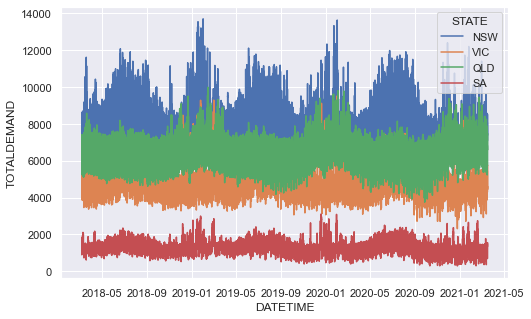

In [62]:
sns.lineplot(data=pv[pv['POWER'].notna()], x='DATETIME', y='TOTALDEMAND',hue='STATE')

In [9]:
# Loop through and read each of the states forecast files, concatenate them to build one large dataframe
# First test with one state (Qld)
# Earliest forecast for Qld is 2017-01-01

forecast = pd.DataFrame()

for state in states:
    state_df = pd.read_csv(DATA_PATH+'forecastdemand_'+state.lower()+'.csv')
    forecast = pd.concat([forecast, state_df], axis = 0)

#forecast = pd.read_csv(DATA_PATH+'forecastdemand_qld.csv')


forecast['DATETIME'] = pd.to_datetime(forecast['DATETIME'])
forecast['LASTCHANGED'] = pd.to_datetime(forecast['LASTCHANGED'])

# Convert the REGIONID to a state name (just drop the '1' at the end)
forecast['STATE'] = forecast['REGIONID'].map(lambda x: x[:-1])
forecast = forecast.drop(['REGIONID'], axis=1)

In [10]:
forecast.shape
forecast.isna().sum()
forecast['STATE'].unique()

(23192795, 6)

PREDISPATCHSEQNO    0
PERIODID            0
FORECASTDEMAND      0
LASTCHANGED         0
DATETIME            0
STATE               0
dtype: int64

array(['NSW', 'VIC', 'SA', 'QLD'], dtype=object)

In [11]:
# Left join on forecast
merged = pd.merge(left=forecast, right=demand, on=['STATE','DATETIME'], how='left', indicator=True)

In [12]:
merged.shape
merged.isna().sum()

(23192795, 22)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND             5016
POWER               11399026
LOCATION                5016
TEMPERATURE             5430
Weekday                 5016
Quarter                 5016
Month                   5016
Season                  5016
Day                     5016
Year                    5016
SUNRISE                 5016
SUNSET                  5016
DAYTYPE                 5016
HOLIDAY                 5016
MEANFORECAST            5016
_merge                     0
dtype: int64

In [13]:
#The unmatched rows are because TOTALDEMAND values are not available after 2021-03-18, so they can be dropped
merged = merged.dropna(subset=['TOTALDEMAND'])

In [14]:
merged.shape
merged.isna().sum()

(23187779, 22)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND                0
POWER               11394010
LOCATION                   0
TEMPERATURE              414
Weekday                    0
Quarter                    0
Month                      0
Season                     0
Day                        0
Year                       0
SUNRISE                    0
SUNSET                     0
DAYTYPE                    0
HOLIDAY                    0
MEANFORECAST               0
_merge                     0
dtype: int64

In [15]:
# Calculate the difference between actual and forecast demand at each timepoint.
# Difference is expressed in terms of TOTALDEMAND - FORECAST, so *over* forecasting is positive, *under* forecasting is positive.
merged['DIFF'] = merged['TOTALDEMAND'] - merged['FORECASTDEMAND']

In [ ]:
# Group the forecasts by PERIODID. This allows analysis of the entire population of forecasts made at the same ahead-of-time-interval.


In [16]:
# The forecast data appears to contain multiple repeated forecasts for each actual timepoint. Many forecast sets only go from 00:00 to 04:00,
# but repeated multiple times for the same set of actual timepoints. It appears only one set of forecasts runs the entire 24 hours for each actual
# day. 
# These could be identified by grouping on PREDISPATCHSEQNO and DATETIME, and choosing the maxcount for each of these groupings

#forecast_df.groupby(['PREDISPATCHSEQNO']).size()

NameError: name 'forecast_df' is not defined

In [17]:
df = merged.groupby(['PERIODID'])['DIFF']


## Distribution of actual - forecast differences over prediction period.

<AxesSubplot:xlabel='PERIODID', ylabel='DIFF'>

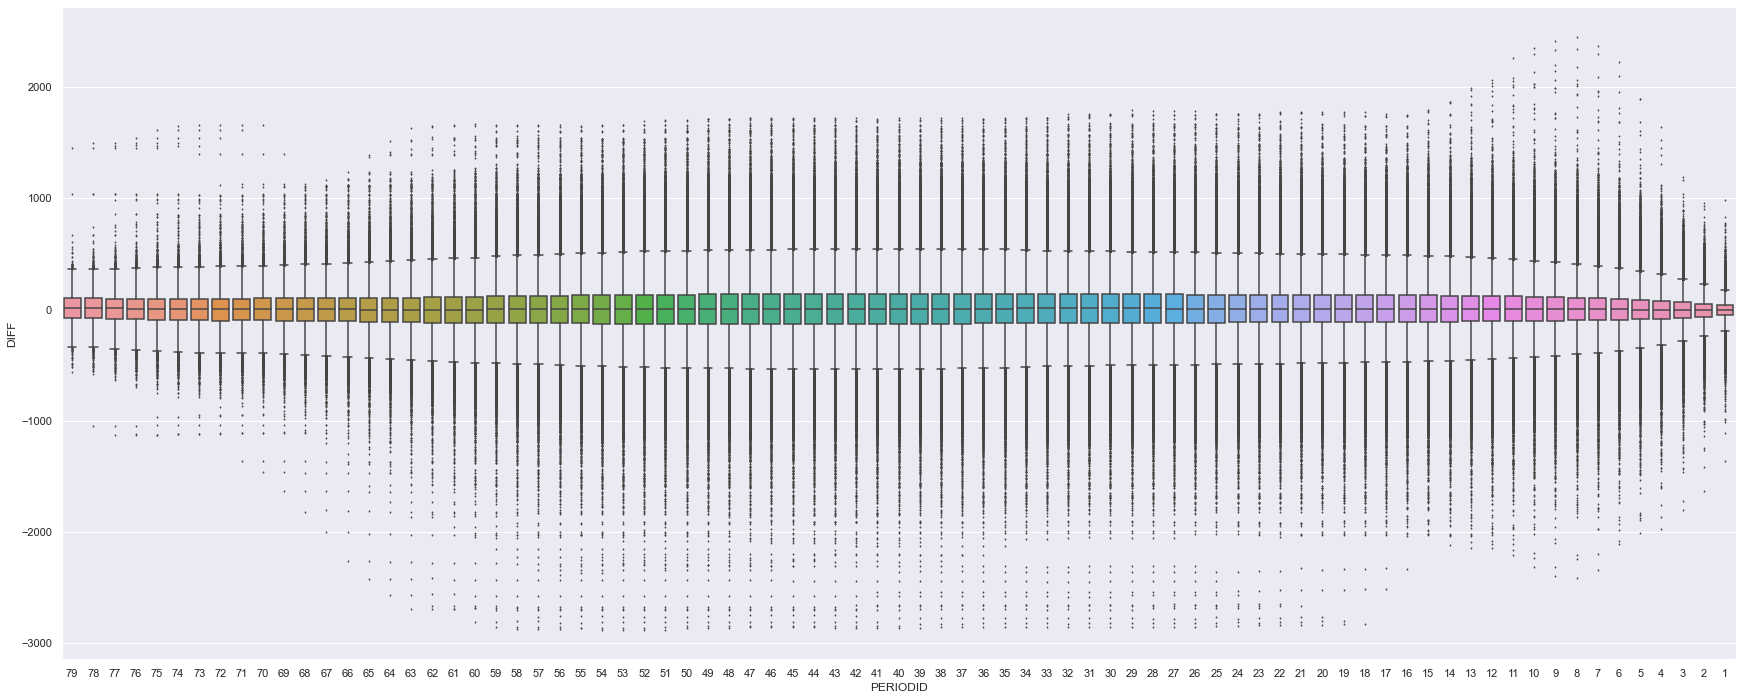

In [20]:

sns.set(rc={"figure.figsize": (30,12)})

# Plot for NSW
# Default for the Seaborn boxplot is whiskers set to 1.5x interquartile range
ordering = list(range(79,0,-1))
sns.boxplot(data = merged[merged['STATE'] == 'NSW'], x='PERIODID',y='DIFF',order=ordering, whis=1.5,fliersize=1)


Some enormous underforecasts for NSW, particularly in the PERIODID range 14-6. Check what they look like directly

In [21]:
merged[(merged['STATE'] == 'NSW') & (merged['DIFF'] > 2000)]['DATETIME'].dt.date.unique().size

2

<AxesSubplot:xlabel='PERIODID', ylabel='DIFF'>

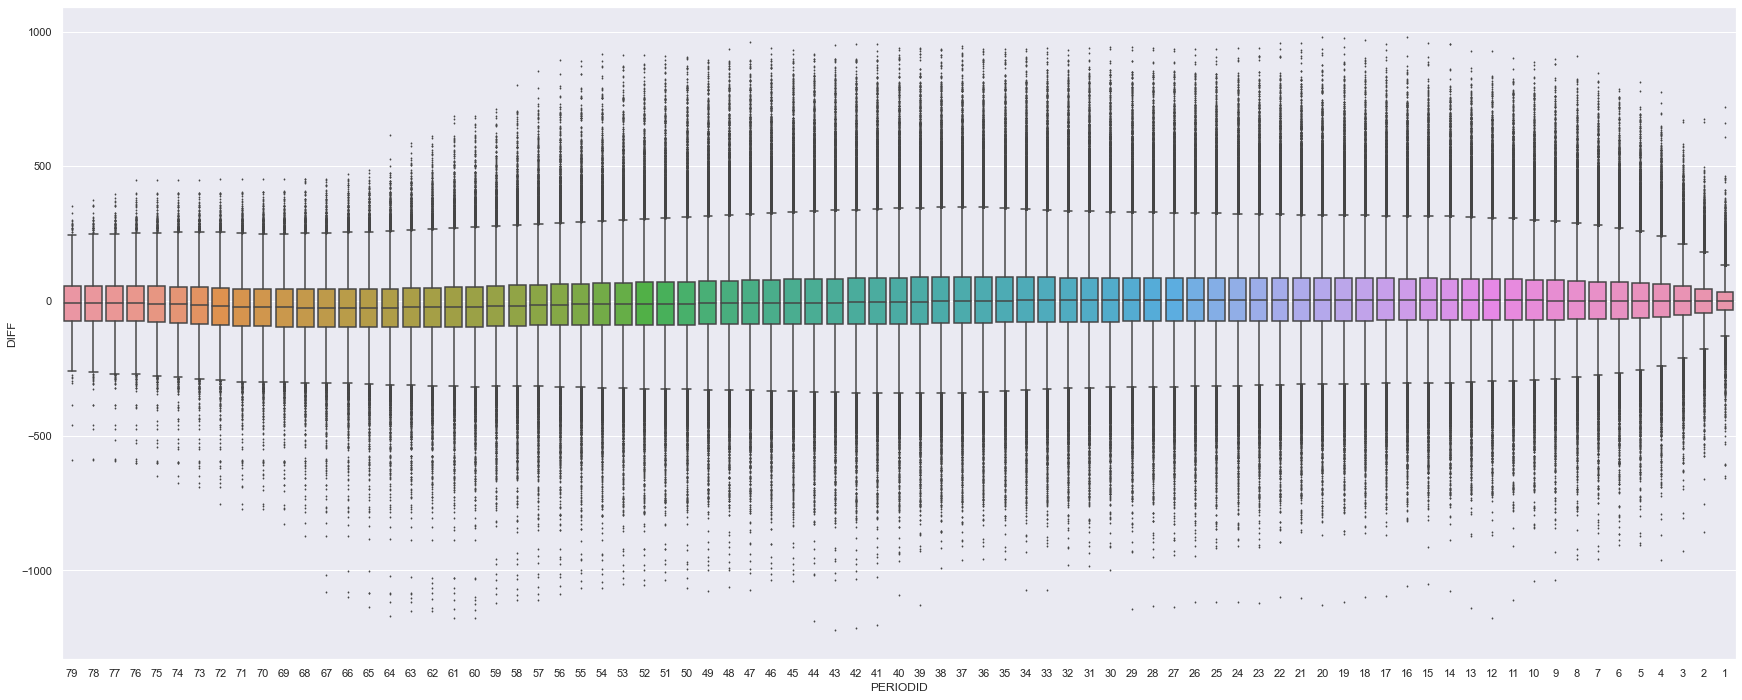

In [22]:
sns.set(rc={"figure.figsize": (30,12)})

# Plot for QLD
# Default for the Seaborn boxplot is whiskers set to 1.5x interquartile range
ordering = list(range(79,0,-1))
sns.boxplot(data = merged[merged['STATE'] == 'QLD'], x='PERIODID',y='DIFF',order=ordering, whis=1.5,fliersize=1)


In [23]:
# Retrieve the outlier forecasts visualised on the boxplot (ie: those greater than 1.5x the IQR)

# Calculate IQRs for each grouped PERIODID for each state

quartiles = pd.DataFrame(columns=['Q1','Q3','IQR'])

quartiles['Q1'] = merged.groupby(['PERIODID','STATE'])['DIFF'].quantile(0.25)
quartiles['Q3'] = merged.groupby(['PERIODID','STATE'])['DIFF'].quantile(0.75)
quartiles['IQR'] = quartiles['Q3'] - quartiles['Q1']

#q1= merged.groupby(['PERIODID'])['DIFF'].quantile(0.25)
#q3 = merged.groupby(['PERIODID'])['DIFF'].quantile(0.75)

#iqr = q3-q1
#iqr
quartiles


Q1        Q3       IQR
PERIODID STATE                             
1        NSW   -55.1400   37.2200   92.3600
         QLD   -32.0400   34.2775   66.3175
         SA    -20.5100   19.1900   39.7000
         VIC   -44.7800   28.0800   72.8600
2        NSW   -66.3500   51.0700  117.4200
...                 ...       ...       ...
78       VIC   -69.7300   81.6900  151.4200
79       NSW   -76.7725  100.5175  177.2900
         QLD   -74.2200   54.9500  129.1700
         SA    -33.9000   39.5000   73.4000
         VIC   -69.6200   81.9900  151.6100

[316 rows x 3 columns]

In [24]:
merged = pd.merge(left=merged, right=quartiles, left_on=['PERIODID','STATE'], right_index=True)

In [25]:
merged.shape
merged.isna().sum()

(23187779, 26)

PREDISPATCHSEQNO           0
PERIODID                   0
FORECASTDEMAND             0
LASTCHANGED                0
DATETIME                   0
STATE                      0
TOTALDEMAND                0
POWER               11394010
LOCATION                   0
TEMPERATURE              414
Weekday                    0
Quarter                    0
Month                      0
Season                     0
Day                        0
Year                       0
SUNRISE                    0
SUNSET                     0
DAYTYPE                    0
HOLIDAY                    0
MEANFORECAST               0
_merge                     0
DIFF                       0
Q1                         0
Q3                         0
IQR                        0
dtype: int64

In [26]:
outliers = merged.query('DIFF <= (Q1 - 1.5 * IQR) or DIFF >= (Q3 + 1.5 * IQR)')

In [27]:
outliers.head(10)

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME,STATE,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,...,SUNRISE,SUNSET,DAYTYPE,HOLIDAY,MEANFORECAST,_merge,DIFF,Q1,Q3,IQR
23976,2010010818,71,7759.02,2010-01-08 12:31:53,2010-01-10 00:00:00,NSW,8247.43,NaN,Bankstown,24.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7892.487042,both,488.41,-99.73,96.3025,196.0325
24048,2010010819,71,7418.94,2010-01-08 13:01:47,2010-01-10 00:30:00,NSW,7889.17,NaN,Bankstown,23.8,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7466.909583,both,470.23,-99.73,96.3025,196.0325
24121,2010010820,71,7151.90,2010-01-08 13:31:38,2010-01-10 01:00:00,NSW,7606.72,NaN,Bankstown,23.8,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,7202.441096,both,454.82,-99.73,96.3025,196.0325
24195,2010010821,71,6891.28,2010-01-08 14:01:46,2010-01-10 01:30:00,NSW,7287.96,NaN,Bankstown,23.0,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6938.060135,both,396.68,-99.73,96.3025,196.0325
24270,2010010822,71,6629.74,2010-01-08 14:31:52,2010-01-10 02:00:00,NSW,7034.07,NaN,Bankstown,22.6,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6687.802133,both,404.33,-99.73,96.3025,196.0325
24346,2010010823,71,6441.34,2010-01-08 15:01:42,2010-01-10 02:30:00,NSW,6880.65,NaN,Bankstown,22.1,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6508.839079,both,439.31,-99.73,96.3025,196.0325
24423,2010010824,71,6350.36,2010-01-08 15:31:51,2010-01-10 03:00:00,NSW,6837.91,NaN,Bankstown,23.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6423.084286,both,487.55,-99.73,96.3025,196.0325
24501,2010010825,71,6309.17,2010-01-08 16:01:42,2010-01-10 03:30:00,NSW,6778.70,NaN,Bankstown,23.2,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6391.098718,both,469.53,-99.73,96.3025,196.0325
24580,2010010826,71,6297.12,2010-01-08 16:31:48,2010-01-10 04:00:00,NSW,6717.56,NaN,Bankstown,23.4,...,2010-01-10 04:56:00,2010-01-10 19:11:00,Night,False,6376.083038,both,420.44,-99.73,96.3025,196.0325
29449,2010011020,71,7699.46,2010-01-10 13:31:40,2010-01-12 01:00:00,NSW,8094.42,NaN,Bankstown,23.3,...,2010-01-12 04:58:00,2010-01-12 19:11:00,Night,False,7954.190411,both,394.96,-99.73,96.3025,196.0325


In [28]:
outliers.isna().sum()

PREDISPATCHSEQNO         0
PERIODID                 0
FORECASTDEMAND           0
LASTCHANGED              0
DATETIME                 0
STATE                    0
TOTALDEMAND              0
POWER               535537
LOCATION                 0
TEMPERATURE              0
Weekday                  0
Quarter                  0
Month                    0
Season                   0
Day                      0
Year                     0
SUNRISE                  0
SUNSET                   0
DAYTYPE                  0
HOLIDAY                  0
MEANFORECAST             0
_merge                   0
DIFF                     0
Q1                       0
Q3                       0
IQR                      0
dtype: int64

<AxesSubplot:xlabel='DIFF', ylabel='TEMPERATURE'>

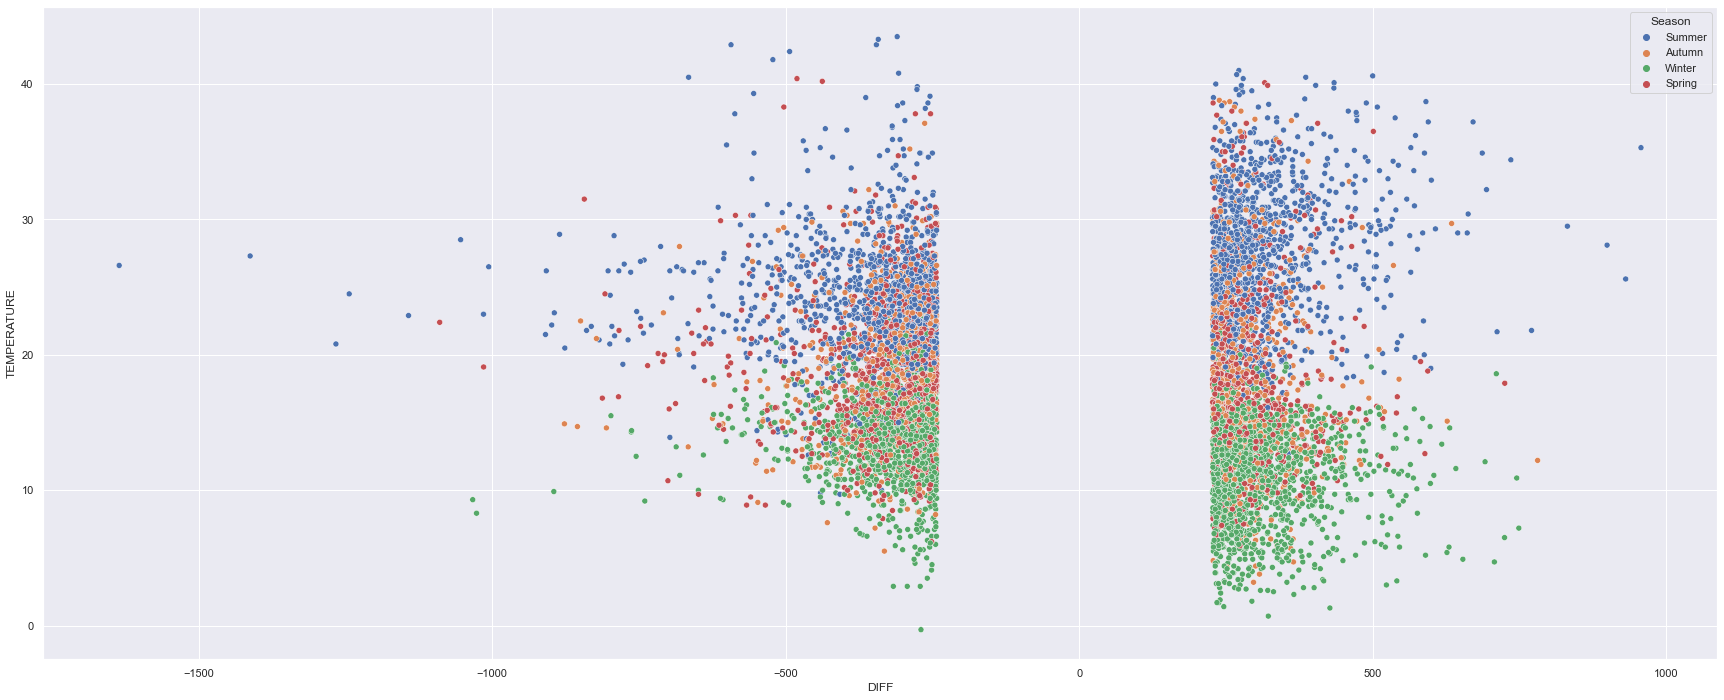

In [86]:
# Plot outliers for NSW according to season
sns.scatterplot(data=outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 2)], x='DIFF',y='TEMPERATURE',hue='Season')

## Distribution of outlier forecasts (for all prediction periods) versus time of day (ie: when are forecasts least reliable?)

### What time of the day do the most mispredictions occur? In what season? In what state?


In [29]:
outliers['TIME'] = outliers['DATETIME'].dt.time

/var/folders/h8/db9ggz8548ddft2yd4yw4kzh0000gq/T/ipykernel_16214/2835706818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['TIME'] = outliers['DATETIME'].dt.time


In [117]:
#outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time).size()

xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['TIME']).size()

#xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time)
#xdf = outliers[(outliers['STATE'] == 'NSW') & (outliers['PERIODID'] == 48)].groupby(outliers['DATETIME'].dt.time)

#xdf.plot(kind='bar')
#sns.histplot(data=xdf, y='TIME')



<AxesSubplot:xlabel='TIME'>

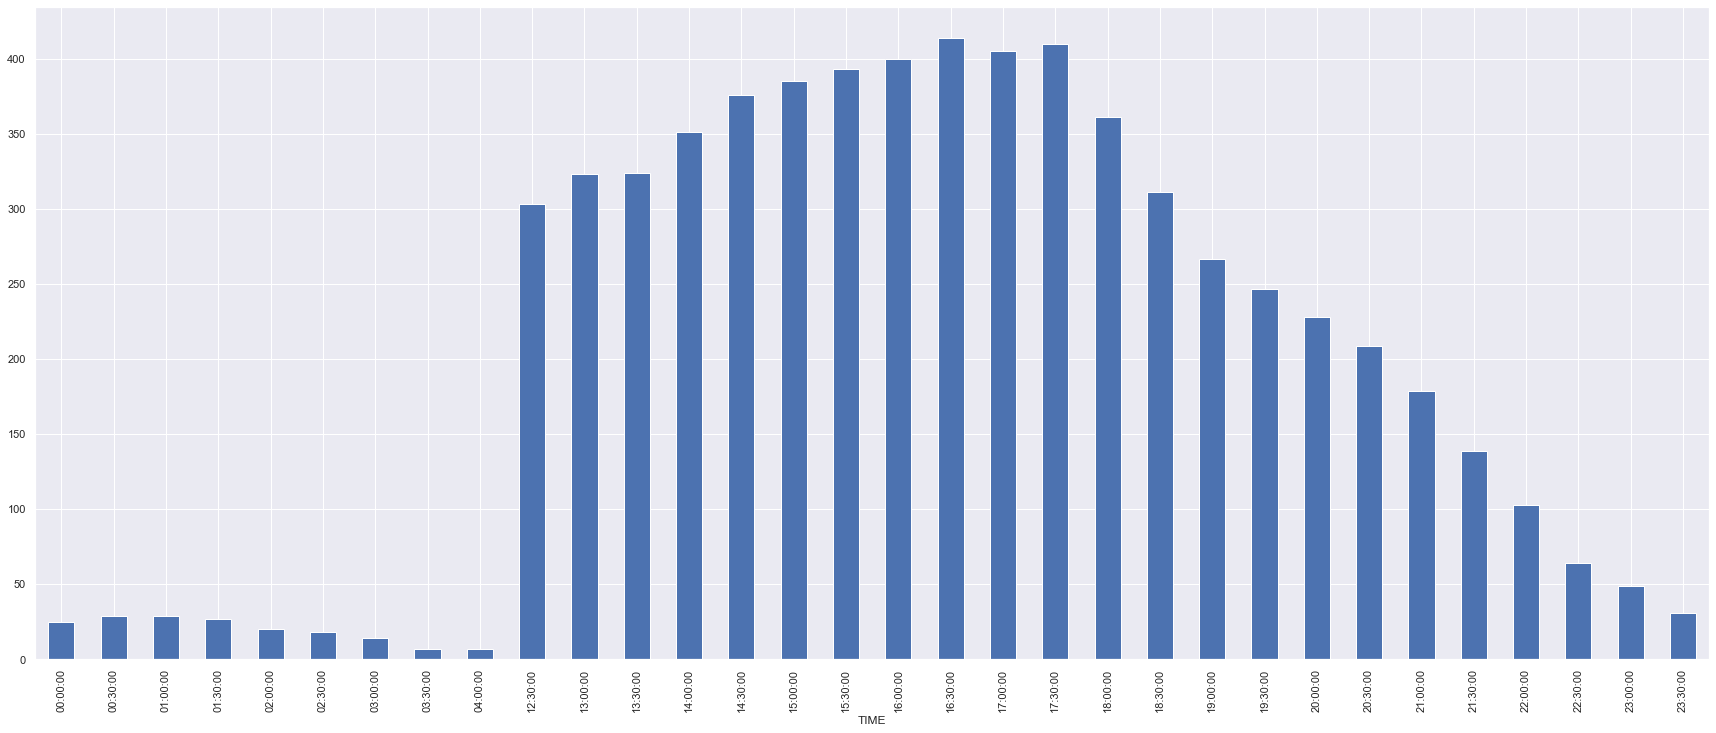

In [118]:
xdf.plot.bar()

In [30]:
# Group the data by TIME and PERIODID and get counts for each combination.
#period_time = outliers[outliers['STATE'] == 'NSW'].groupby(['TIME','PERIODID']).size()
period_time = outliers.groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')


<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

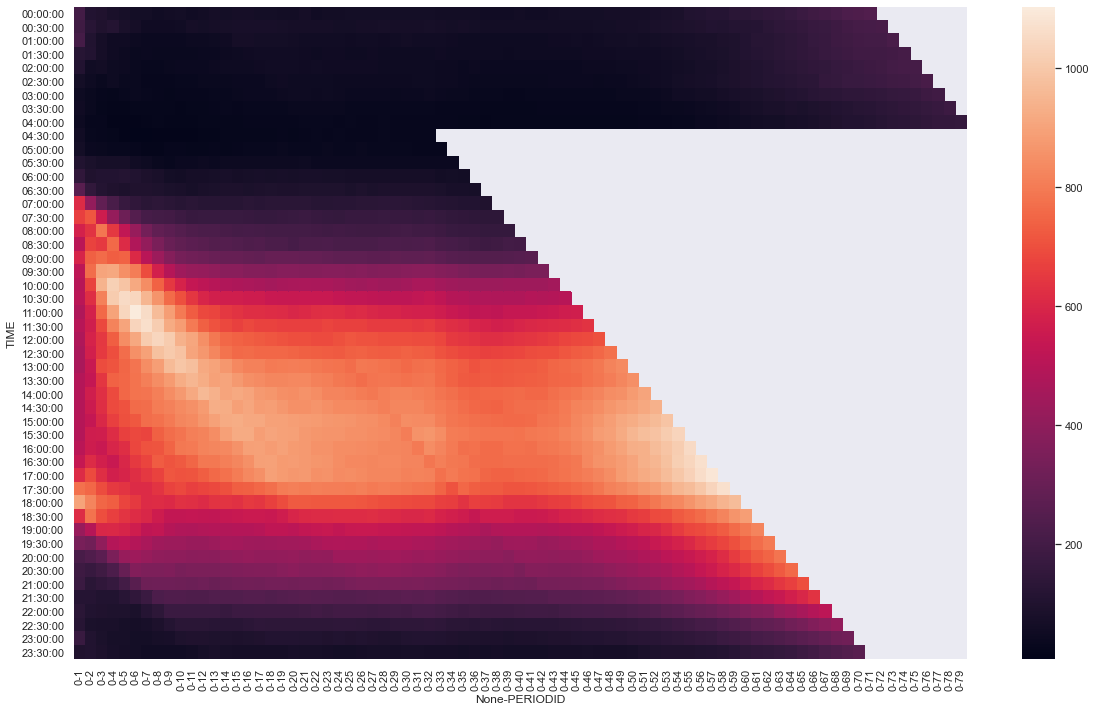

In [32]:
sns.set(rc={"figure.figsize": (20,12)})
sns.heatmap(pivot_df)

<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

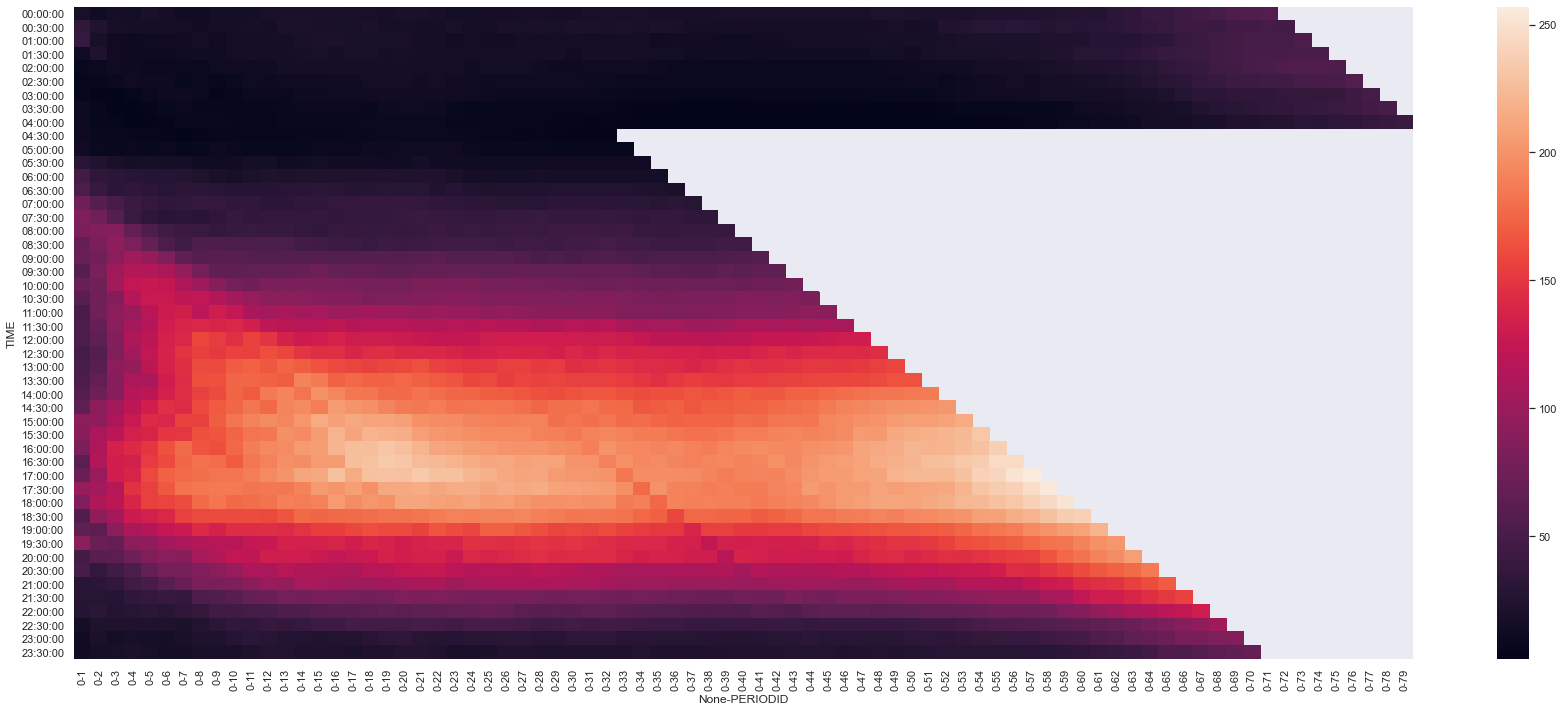

In [80]:
# Group the data by TIME and PERIODID and get counts for each combination.
period_time = outliers[(outliers['STATE'] == 'NSW') & (outliers['Season'] == 'Summer')].groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')
sns.heatmap(pivot_df)

<AxesSubplot:xlabel='None-PERIODID', ylabel='TIME'>

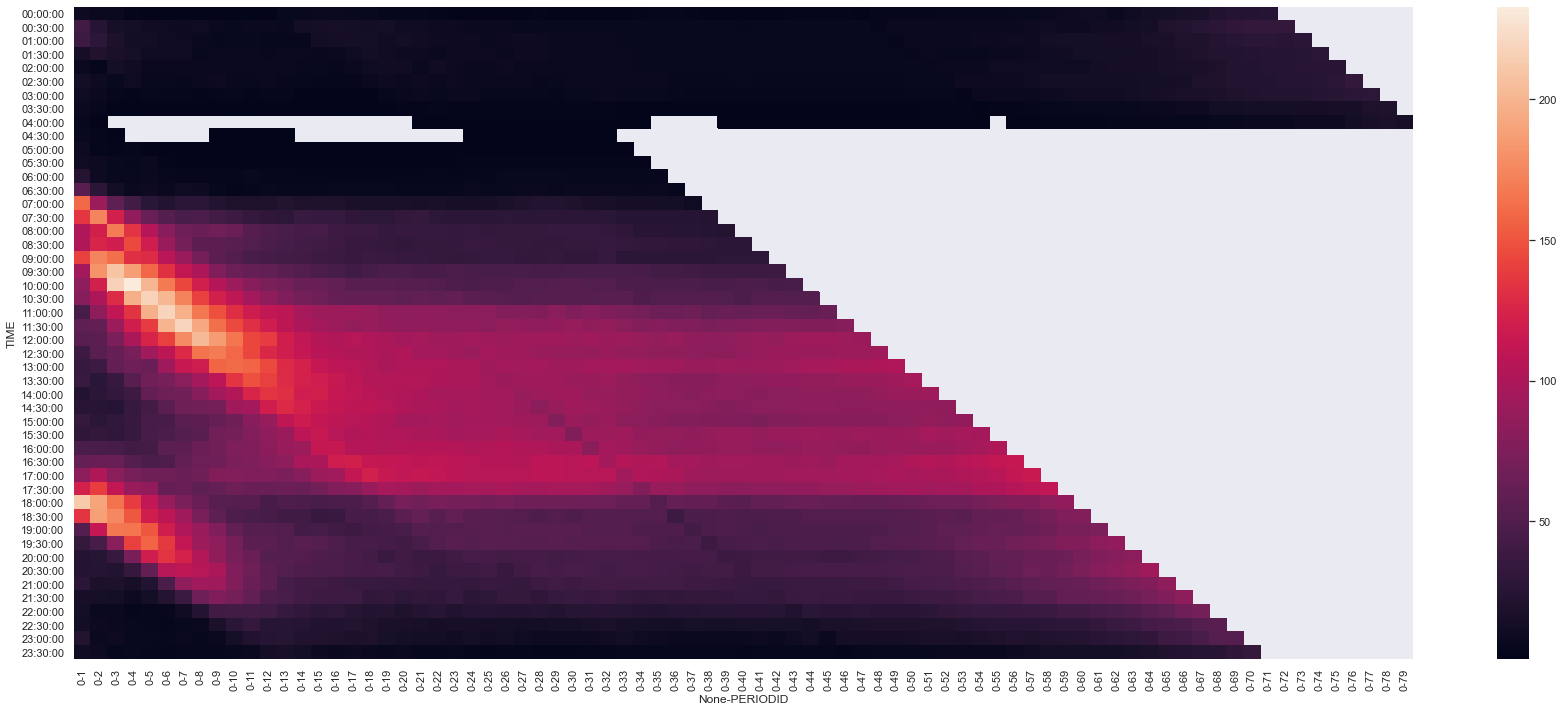

In [81]:
# Group the data by TIME and PERIODID and get counts for each combination.
period_time = outliers[(outliers['STATE'] == 'NSW') & (outliers['Season'] == 'Winter')].groupby(['TIME','PERIODID']).size()

# Pivot into a form compatible with sns.heatmap
pivot_df = period_time.reset_index().pivot(columns='PERIODID',index='TIME')
sns.heatmap(pivot_df)

In [219]:
# Covariance calculations for DIFF, TEMP, POWER for PERIODID = 2 (1 hour ahead forecast)
cov_df = merged[(merged['PERIODID'] == 2)]
cov_df = cov_df.set_index('DATETIME')

In [217]:
cov_df = cov_df.dropna()

In [220]:
cov_df['POWER-1H'] = cov_df['POWER'] - cov_df['POWER'].shift(2)
cov_df['TEMPERATURE-1H'] = cov_df['TEMPERATURE'] - cov_df['TEMPERATURE'].shift(2)

In [182]:
cov_df.head(20)

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,LASTCHANGED,STATE,TOTALDEMAND,POWER,LOCATION,TEMPERATURE,Weekday,...,DAYTYPE,HOLIDAY,MEANFORECAST,_merge,DIFF,Q1,Q3,IQR,POWER-1H,TEMPERATURE-1H
DATETIME,,,,,,,,,,,,,,,,,,,,,
2018-03-06 09:30:00,2018030610,2,8374.66,2018-03-06 08:31:05,NSW,8325.67,427.281,Bankstown,21.8,Tuesday,...,Day,False,8432.046190,both,-48.99,-66.35,51.07,117.42,NaN,NaN
2018-03-06 10:00:00,2018030611,2,8358.52,2018-03-06 09:00:51,NSW,8338.62,495.195,Bankstown,21.5,Tuesday,...,Day,False,8413.074419,both,-19.90,-66.35,51.07,117.42,NaN,NaN
2018-03-06 10:30:00,2018030612,2,8261.23,2018-03-06 09:30:52,NSW,8323.66,516.137,Bankstown,22.7,Tuesday,...,Day,False,8367.147273,both,62.43,-66.35,51.07,117.42,88.856,0.9
2018-03-06 11:00:00,2018030613,2,8220.58,2018-03-06 10:00:50,NSW,8264.99,549.542,Bankstown,22.1,Tuesday,...,Day,False,8334.082667,both,44.41,-66.35,51.07,117.42,54.347,0.6
2018-03-06 11:30:00,2018030614,2,8214.50,2018-03-06 10:30:49,NSW,8247.11,556.764,Bankstown,22.5,Tuesday,...,Day,False,8289.618478,both,32.61,-66.35,51.07,117.42,40.627,-0.2
2018-03-06 12:00:00,2018030615,2,8249.13,2018-03-06 11:00:59,NSW,8249.70,605.312,Bankstown,23.0,Tuesday,...,Day,False,8272.324894,both,0.57,-66.35,51.07,117.42,55.770,0.9
2018-03-06 12:30:00,2018030616,2,8276.55,2018-03-06 11:30:53,NSW,8201.18,622.850,Bankstown,23.2,Tuesday,...,Day,False,8276.585208,both,-75.37,-66.35,51.07,117.42,66.086,0.7
2018-03-06 13:00:00,2018030617,2,8302.44,2018-03-06 12:00:49,NSW,8184.98,623.553,Bankstown,23.6,Tuesday,...,Day,False,8290.181837,both,-117.46,-66.35,51.07,117.42,18.241,0.6
2018-03-06 13:30:00,2018030618,2,8329.27,2018-03-06 12:31:45,NSW,8175.64,620.090,Bankstown,23.9,Tuesday,...,Day,False,8304.281800,both,-153.63,-66.35,51.07,117.42,-2.760,0.7


In [221]:
# Correlation matrix for DIFF outliers above 1.5 times the interquartile range
cov_df.query('DIFF >= (Q3 + 1.5 * IQR)')[['TOTALDEMAND','POWER','POWER-1H','TEMPERATURE','TEMPERATURE-1H','DIFF']].corr()

#cov_df[cov_df['DIFF'] >= (1.5 * cov_df['IQR'])].corr()

,TOTALDEMAND,POWER,POWER-1H,TEMPERATURE,TEMPERATURE-1H,DIFF
TOTALDEMAND,1.000000,0.145727,-0.138825,-0.145399,-0.062212,0.653772
POWER,0.145727,1.000000,-0.074236,0.475241,0.247928,0.138893
POWER-1H,-0.138825,-0.074236,1.000000,-0.277671,0.461211,-0.117377
TEMPERATURE,-0.145399,0.475241,-0.277671,1.000000,0.078910,-0.139274
TEMPERATURE-1H,-0.062212,0.247928,0.461211,0.078910,1.000000,0.004153
DIFF,0.653772,0.138893,-0.117377,-0.139274,0.004153,1.000000


<AxesSubplot:xlabel='POWER', ylabel='DIFF'>

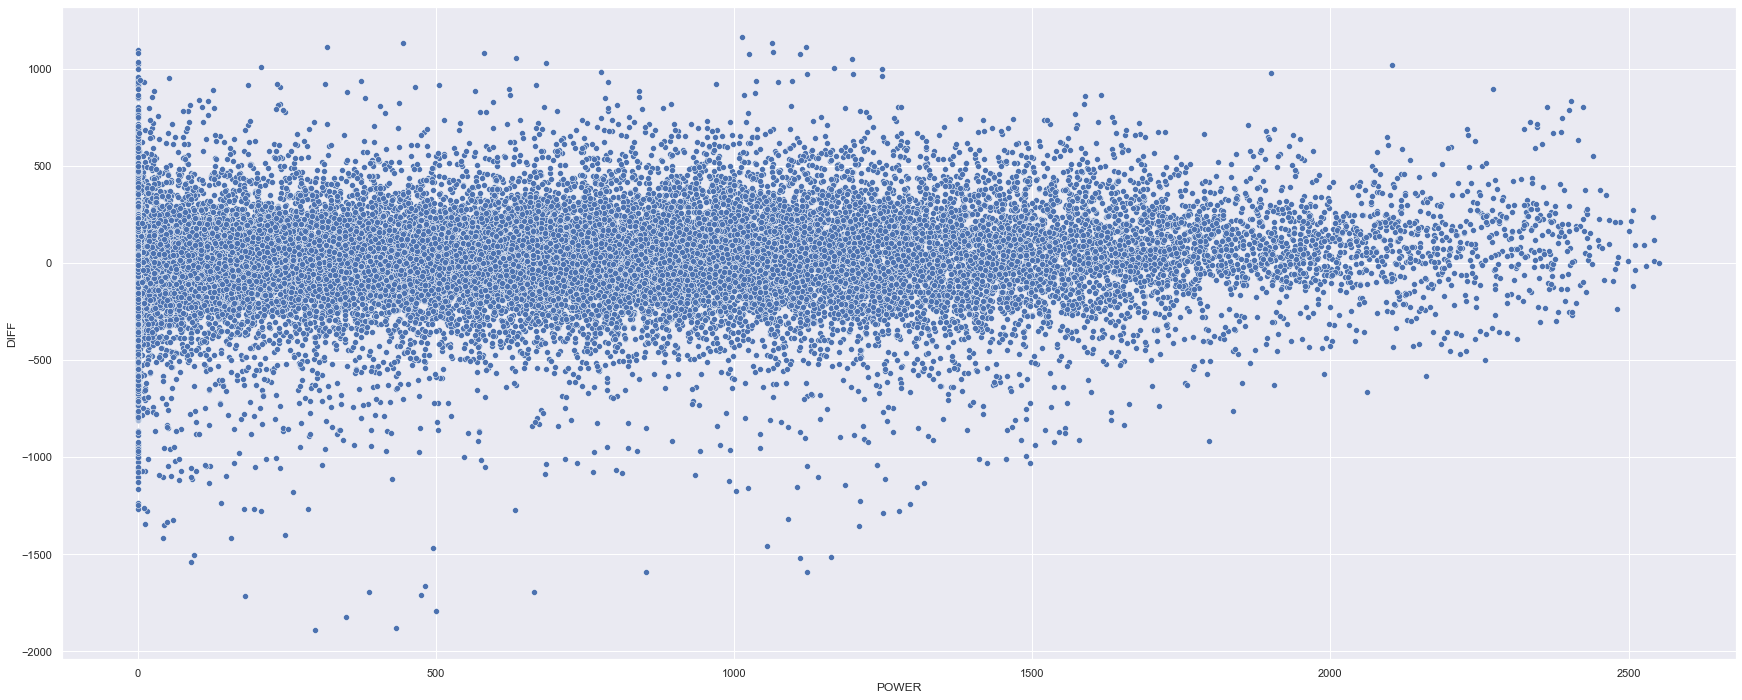

In [218]:
import seaborn as sns
sns.scatterplot(data=cov_df, x='POWER',y='DIFF')